# Week 5: Lasso

The purpose of this week's exercises is to get our hands dirty using tools for high-dimensional estimation. We will here focus on the Lasso. However, most if not all exercises below can be done for the Ridge estimator, Dantzig selector, and the Elastic Net. (Do it!) We will use the "housing.csv" dataset, which contains data on house prices and more across districts in California. 

(The dataset is a slightly modified version of one initially featured in the paper "Sparse spatial autoregressions" by Pace and Barry in Statistics & Probability Letters 33.3 (1997), pp. 291-297. The data derive from the 1990 census, so it will sadly not help you predict current house prices)

We first read the data into Python and explore the dataset to begin with.

In [1]:
# Read data
import pandas as pd
housing = pd.read_csv("housing.csv")
print("The number of rows and colums are {} and also called shape of the matrix".format(housing.shape)) # data dimensions
print("Columns names are \n {}".format(housing.columns))
print(housing.head()) # first observations
print(housing.tail()) # last observations
print(housing.dtypes) # data types
housing.isnull().sum() # check for missing values

The number of rows and colums are (20640, 10) and also called shape of the matrix
Columns names are 
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Some observations are missing a bedroom count. We here drop those. (An alternative approach is to impute the mean or median value and use all observations. Do it!)

In [2]:
housing=housing.dropna()
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

We will model house prices (median_house_value) using a linear (in the parameters) model of the remaining basic regressors minus "ocean_proximity". (The latter variable is likely a predictor of house prices. However, due to its categorical nature, we will exclude it for the purpose of this exercise. A better  approach is to convert this categorical variable into a collection of dummies.)

In [3]:
y = housing.median_house_value
X = housing.drop(["median_house_value","ocean_proximity"],axis=1)
print(X.head()) # first regressor observations

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  
0       322.0       126.0         8.3252  
1      2401.0      1138.0         8.3014  
2       496.0       177.0         7.2574  
3       558.0       219.0         5.6431  
4       565.0       259.0         3.8462  


## Exercises
1. Standardize the candidate regressors to bring everything onto the same scale.

In [4]:
import numpy as np
muhat = np.mean(X,axis = 0)
stdhat = np.std(X,axis = 0)
Xn = (X - muhat)/stdhat

2. Construct a grid of candidate penalty levels from 1 to 80000, and estimate the linear model for each of these penalty levels while saving the coefficient estimates.
[Hints: sklearn.linear_model.Lasso and numpy.geomspace may come in handy.]

In [5]:
lambda_grid = np.geomspace(10,1e5) # log-equispaced
from sklearn.linear_model import Lasso
coefs=[]
for lamb in lambda_grid:
    fit=Lasso(alpha = lamb).fit(Xn,y) # estimate
    coefs.append(fit.coef_)

3. Plot the (standardized) coefficient estimates as a function of the penalty level, i.e.
create what is known as the Lasso path. [Hints: One option is matplotlib.pyplot, which also allows you to specify a logarithmic first axis using set_xscale('log').]

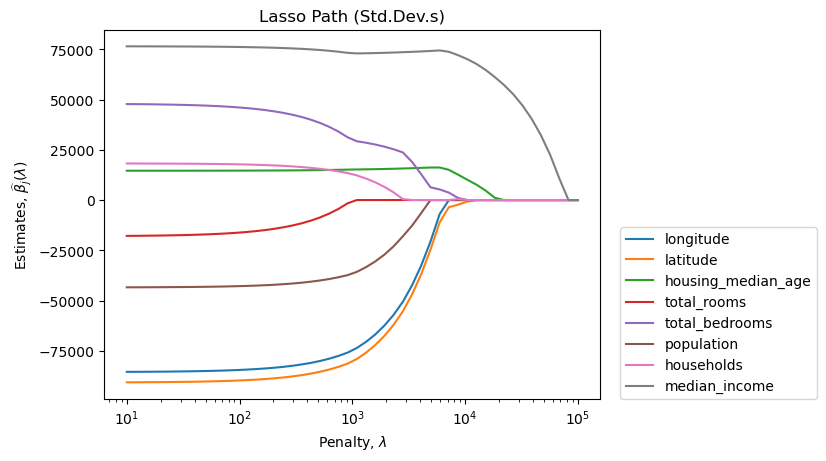

In [6]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(lambda_grid, coefs) 
ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.title('Lasso Path (Std.Dev.s)')
XNames=np.array(X.columns)
lgd=ax.legend(XNames,loc=(1.04,0))
plt.show()

4. Compute the penalty level and estimates implied by 5-fold cross-validation (5-CV). Which variables are selected by 5-CV? [Hint: Use sklearn.linear_model.LassoCV.]

In [7]:
from sklearn.linear_model import LassoCV
fit_cv=LassoCV(cv=5).fit(Xn,y)
lambda_cv=fit_cv.alpha_ 
coef_cv=fit_cv.coef_
sel_cv=(coef_cv!=0)
print(round(lambda_cv))
print(np.round(coef_cv))
XNames=np.array(X.columns)
print(sel_cv)
print(XNames[sel_cv]) 

79
[-84766. -89996.  14628. -16565.  46444. -42979.  17859.  76241.]
[ True  True  True  True  True  True  True  True]
['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income']


chosen lambda by CV: 0.001
Minimal possible lambda by CV: 0.001


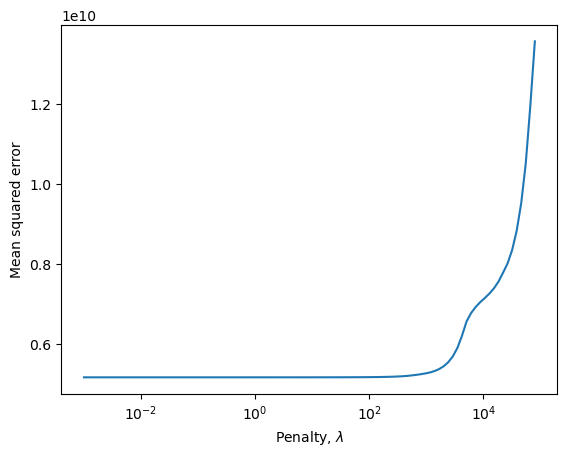

In [8]:
n = 100
L = np.geomspace(0.001,80000,n)
fit_cv1 = LassoCV(cv=5, alphas=L).fit(Xn,y)
lambda1_CV = fit_cv1.alpha_
print("chosen lambda by CV:", fit_cv1.alpha_)
print("Minimal possible lambda by CV:", np.min(fit_cv1.alphas_))

#error path 
ax = plt.gca()
ax.plot(fit_cv1.alphas_, np.mean(fit_cv1.mse_path_, axis=1)) 
ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel('Mean squared error')
plt.show()

5. Visualize the estimates resulting from 5-CV by adding a vertical line
to your Lasso path at the corresponding penalty level. [Hint: Use axvline.]

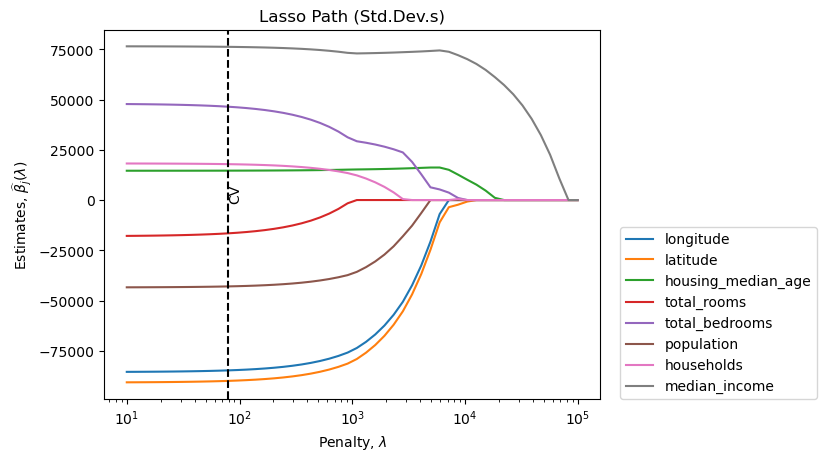

In [9]:
ax = plt.gca()
ax.plot(lambda_grid, coefs) 
ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.title('Lasso Path (Std.Dev.s)')
XNames=np.array(X.columns)
lgd=ax.legend(XNames,loc=(1.04,0))
ax.axvline(x=lambda_cv,c='k',linestyle='--') # <-- new
plt.text(lambda_cv,0,'CV',rotation=90) # <-- new
plt.show()

6. Compute the (feasible) Bickel-Ritov-Tsybakov (BRT) penalty level, the resulting Lasso estimates, and visualize them in your path. Compare the BRT results to the CV
ones. [Hint: scipy.stats.norm.ppf gives you the inverse of the normal CDF.] 

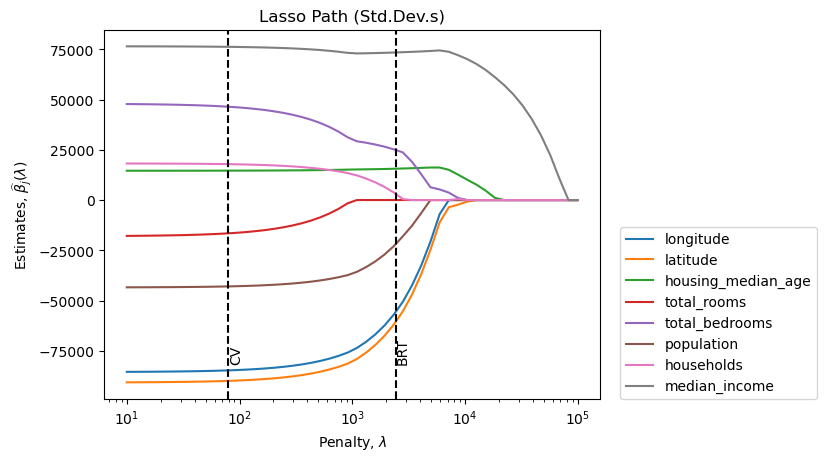

In [10]:
# BRT
# Penalty
from scipy.stats import norm
sigmahat = np.std(y)
n,p = X.shape
c = 1.1; alpha = 0.05
lambda_brt = c*sigmahat*norm.ppf(1-alpha/(2*p))/np.sqrt(n) 
# Note: Have divided by 2 due to Python definition of Lasso

# Implied estimates and selection
coef_brt=Lasso(alpha=lambda_brt).fit(Xn,y).coef_
sel_brt=(coef_brt!=0)

# Visualized along path
ax = plt.gca()
ax.plot(lambda_grid, coefs) 
ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.title('Lasso Path (Std.Dev.s)')
XNames=np.array(X.columns)
lgd=ax.legend(XNames,loc=(1.04,0))
ax.axvline(x=lambda_cv,c='k',linestyle='--')
plt.text(lambda_cv+2,-80000,'CV',rotation=90) 
ax.axvline(x=lambda_brt,c='k',linestyle='--') # <-- new
plt.text(lambda_brt+2,-80000,'BRT',rotation=90) # <-- new
plt.show()

7. Compute the Belloni-Chen-Chernozhukov-Hansen (BCCH) pilot and updated penalty levels, the resulting Lasso estimates, and add them to your path. Compare
the BCCH penalty and estimates to both the CV and BRT ones.

In [11]:
# BCCH
# Pilot penalty
from scipy.stats import norm
from numpy.matlib import repmat
n,p = X.shape
c = 1.1; alpha = 0.05
yXscale = (np.max((Xn.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
lambda_pilot = c*norm.ppf(1-alpha/(2*p))*yXscale/np.sqrt(n)
# Note: Have divided by 2 due to Python definition of Lasso

# Pilot estimates
#Create predicted value - two ways:
coef_pilot = Lasso(alpha=lambda_pilot).fit(Xn,y).coef_
coef_intercept = Lasso(alpha=lambda_pilot).fit(Xn,y).intercept_
pred = (coef_intercept + Xn@coef_pilot)
pred = Lasso(alpha=lambda_pilot).fit(Xn,y).predict(Xn)

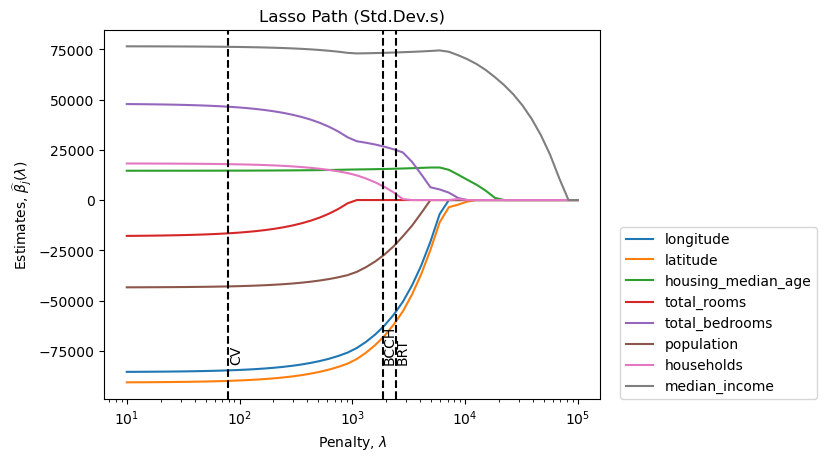

In [12]:
# Updated penalty
res = y - pred
resXscale = (np.max((Xn.T ** 2) @ (res ** 2) / n)) ** 0.5
lambda_bcch = c*norm.ppf(1-alpha/(2*p))*resXscale/np.sqrt(n)

# Updated estimates
coef_bcch = Lasso(alpha=lambda_bcch).fit(Xn,y).coef_
sel_bcch = (coef_bcch != 0)

# Visualized along path
ax = plt.gca()
ax.plot(lambda_grid, coefs) 
ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.title('Lasso Path (Std.Dev.s)')
XNames=np.array(X.columns)
lgd=ax.legend(XNames,loc=(1.04,0))
ax.axvline(x=lambda_cv,c='k',linestyle='--')
plt.text(lambda_cv+2,-80000,'CV',rotation=90) 
ax.axvline(x=lambda_brt,c='k',linestyle='--') 
plt.text(lambda_brt+2,-80000,'BRT',rotation=90)
ax.axvline(x=lambda_bcch,c='k',linestyle='--')  # <-- new
plt.text(lambda_bcch+2,-80000,'BCCH',rotation=90) # <-- new
plt.show()

In [13]:
# print penalty levels
print("lambda_cv = ",lambda_cv.round(2))
print("lambda_brt = ",lambda_brt.round(2))
print("lambda_pilot = ",lambda_pilot.round(2))
print("lambda_bcch = ",lambda_bcch.round(2))

lambda_cv =  79.46
lambda_brt =  2428.92
lambda_pilot =  4254.89
lambda_bcch =  1866.5


8. Gather the estimates in a table. [Hint: One option is to create a pandas.Dataframe.]

In [14]:
data_as_dict = {'CV':coef_cv, 'BRT':coef_brt, 'BCCH':coef_bcch}
pd.DataFrame(data_as_dict, index=XNames).astype(int)

,CV,BRT,BCCH
longitude,-84766,-55772,-63318
latitude,-89995,-60676,-68463
housing_median_age,14628,15594,15437
total_rooms,-16565,0,0
total_bedrooms,46443,24936,26764
population,-42979,-21994,-27803
households,17858,3115,6979
median_income,76240,73438,73236


9. (Optional) Redo the entire exercise after having added squares of the basic regressors. Note that creating the Lasso path may take a while and the algorithm may fail to converge at low penalty levels. [Hints: Create squares and use numpy.hstack to add them to the regressors in levels. You may also use sklearn.preprocessing.PolynomialFeatures to further add interaction terms.]

In [15]:
# Adding quadratics and normalizing anew
Xtech = np.hstack((X,X ** 2))
Xtechn = (Xtech - np.mean(Xtech,axis = 0))/np.std(Xtech,axis = 0)
lambda_grid = np.geomspace(10,1e5) # log-equispaced
from sklearn.linear_model import Lasso
coefs_tech=[]
for lamb in lambda_grid:
    fit=Lasso(alpha = lamb,max_iter=1000000).fit(Xtechn,y) # estimate
    coefs_tech.append(fit.coef_)

In [16]:
# CV
from sklearn.linear_model import LassoCV
fit_cv_tech=LassoCV(cv=5,max_iter=1000000).fit(Xtechn,y)
lambda_cv_tech=fit_cv_tech.alpha_

chosen lambda by CV: 74.05948693701455
Minimal possible lambda by CV: 0.001


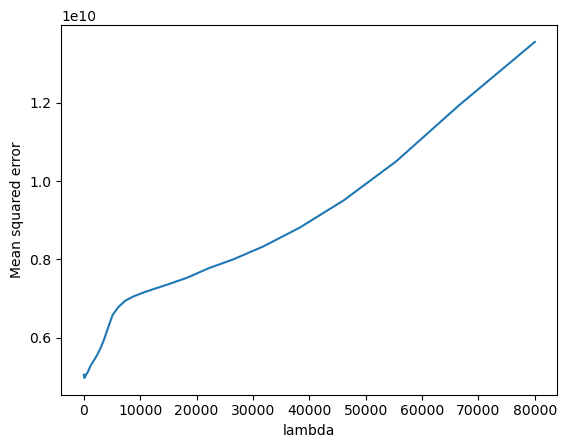

In [17]:
n = 100
L = np.geomspace(0.001,80000,n)
fit_cv2 = LassoCV(cv=5,alphas=L, max_iter=1000000).fit(Xtechn,y)
lambda2_CV = fit_cv2.alpha_
print("chosen lambda by CV:", fit_cv2.alpha_)
print("Minimal possible lambda by CV:", np.min(fit_cv2.alphas_))

#error path 
plt.plot(fit_cv2.alphas_, np.mean(fit_cv2.mse_path_, axis=1))
plt.xlabel("lambda")
plt.ylabel("Mean squared error")
plt.show()

#Set lambda to a low value...
lambda_cv_tech = 10

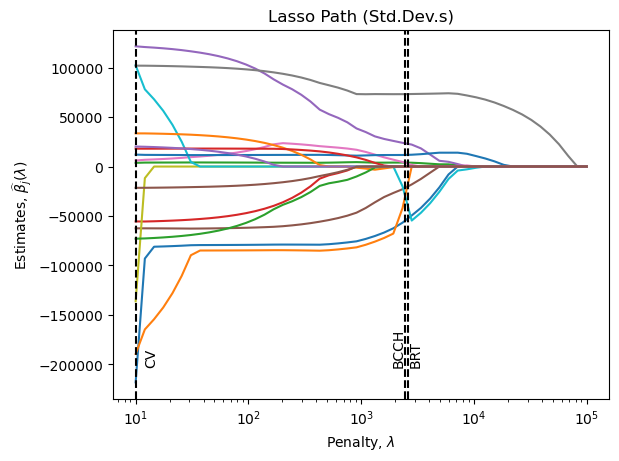

In [20]:
# BRT
# Penalty
from scipy.stats import norm
sigmahat = np.std(y)
n,pnew = Xtech.shape
c = 1.1; alpha = 0.05
lambda_brt_tech = c*sigmahat*norm.ppf(1-alpha/(2*pnew))/np.sqrt(n) 
# Note: Have divided by 2 due to Python definition of Lasso

# Implied estimates and selection
coef_brt_tech=Lasso(alpha=lambda_brt_tech, max_iter=int(1e6)).fit(Xn,y).coef_
sel_brt_tech=(coef_brt_tech!=0)

# BCCH
# Pilot penalty
yXtechscale = (np.max((Xtechn.T ** 2) @ ((y - np.mean(y)) ** 2) / n)) ** 0.5
lambda_pilot_tech = c*norm.ppf(1-alpha/(2*pnew))*yXtechscale/np.sqrt(n)
# Note: Have divided by 2 due to Python definition of Lasso

# Pilot estimates
coef_pilot_tech = Lasso(alpha=lambda_pilot_tech, max_iter=int(1e6)).fit(Xtechn,y).coef_
intercept_pilot_tech = Lasso(alpha=lambda_pilot_tech, max_iter=int(1e6)).fit(Xtechn,y).intercept_

# Updated penalty
res_tech = y - (intercept_pilot_tech + Xtechn @ coef_pilot_tech)
resXtechscale = (np.max((Xtechn.T ** 2) @ (res_tech ** 2) / n)) ** 0.5
lambda_bcch_tech = c*norm.ppf(1-alpha/(2*pnew))*resXtechscale/np.sqrt(n)

# Updated estimates
coef_bcch_tech = Lasso(alpha=lambda_bcch_tech, max_iter=int(1e6)).fit(Xtechn,y).coef_
sel_bcch_tech = (coef_bcch_tech != 0)

# Visualized along path
ax = plt.gca()
ax.plot(lambda_grid, coefs_tech) 
ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.title('Lasso Path (Std.Dev.s)')
ax.axvline(x=lambda_cv_tech,c='k',linestyle='--')
plt.text(lambda_cv_tech+2,-200000,'CV',rotation=90) 
ax.axvline(x=lambda_brt_tech,c='k',linestyle='--') 
plt.text(lambda_brt_tech+2,-200000,'BRT',rotation=90)
ax.axvline(x=lambda_bcch_tech,c='k',linestyle='--') 
plt.text(lambda_bcch_tech-600,-200000,'BCCH',rotation=90) 
plt.show()
# Note: Too crowded to be informative.

When it comes to the exact estimates, the resulting plot is here too crowded to be informative. But the plot still illustrates the expected order of the three penalty levels.